# Inequality in U.S. Senate Representation - Visualized

by the most illustrious and puissant [Philip Mann](https://github.com/philmann7).

---

The *Constitution of the United States* came into force as the supreme law of the United States of America in 1789. The Constitution established, among other bodies, that part of the Congress known as the House of Representatives. Seats in the House are distributed to states in proportion to their population. To facilitate the accurate allotment of seats in the House, the Constitution also mandated that a census be conducted every ten years. 

The Constitution also established an "upper house" of the legislature, in contrast to the so called "lower house," that being the House of Representatives. This upper house is called the Senate, the name a reference to the ancient Roman Senate. While the House of Representatives allocates its seats based on population, the Senate doesn't take population into account; it simply grants two seats to each state.

Let us explore the consequences of this method of apportionment.

---
We'll use some standard data libraries for our explorations.

In [137]:
import json

In [138]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
import matplotlib.pyplot as plt

In [139]:
# Default theme
sns.set_theme()

---

## Collecting our data

First we'll grab historical population data for U.S. States. We'd like data from the official U.S. census; unfortunately the official census website isn't easy to deal with and doesn't appear to have all the data in one place, but the data has been collated by Iowa State University for the 1850 census onwards. For censuses before that year, I've transcribed the data from a census document.

We'll also want to know when each state gained statehood, because that's when they're awarded senate seats. That data we'll get from wikipedia.

### Population Data

The following data was downloaded from [Iowa State University](https://www.icip.iastate.edu/tables/population/census-states). This page is data compiled from the U.S. census.

In [140]:
state_populations = pd.read_csv('state_populations.csv')
state_populations.head()

,FIPS,Areaname,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
0,0,United States,23191876,31443321,38558371,50189209,62979766,76212168,92228496,106021537,123202624,132164569,151325798,179323175,203302031,226542199,248709873,281421906,308745538,331449281
1,1,Alabama,771623,964201,996992,1262505,1513401,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444354,3894025,4040587,4447100,4779736,5024279
2,2,Alaska,na,na,na,33426,32052,63592,64356,55036,59278,72524,128643,226167,302853,401851,550043,626932,710231,733391
3,4,Arizona,na,na,9658,40440,88243,122931,204354,334162,435573,499261,749587,1302161,1775399,2716546,3665228,5130632,6392017,7151502
4,5,Arkansas,209897,435450,484471,802525,1128211,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923322,2286357,2350725,2673400,2915918,3011524


In [141]:
# drop useless columns - FIPS is an identifier used by the census
state_populations.drop('FIPS', axis=1, inplace=True)

In [142]:
state_populations.shape

(52, 19)

In [143]:
# replace 'na' with NaN
state_populations.replace(to_replace='na', value=np.nan, inplace=True)
# set areaname as index
state_populations.set_index('Areaname', inplace=True)

Data from before 1850 was not in the Iowa State dataset. I transcribed this data from a census document retrieved from the following link:
https://web.archive.org/web/20141121134738/http://www.census.gov/population/www/documentation/twps0056/tabs15-65.pdf

In [144]:
# add in data from before 1850
state_populations_historical = pd.read_csv('state_populations_historical.csv')
# set area name as index
state_populations_historical.set_index('Areaname', inplace=True)

# join both dataframes
state_populations = state_populations_historical.join(state_populations)
state_populations.head()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,...,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
Areaname,,,,,,,,,,,,,,,,,,,,,
United States,NaN,NaN,NaN,NaN,NaN,NaN,23191876,31443321,38558371,50189209,...,123202624,132164569,151325798,179323175,203302031,226542199,248709873,281421906,308745538,331449281
Alabama,NaN,1250.0,9046.0,127901.0,309527.0,590756.0,771623,964201,996992,1262505,...,2646248,2832961,3061743,3266740,3444354,3894025,4040587,4447100,4779736,5024279
Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33426,...,59278,72524,128643,226167,302853,401851,550043,626932,710231,733391
Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9658,40440,...,435573,499261,749587,1302161,1775399,2716546,3665228,5130632,6392017,7151502
Arkansas,NaN,NaN,1062.0,14273.0,30388.0,97574.0,209897,435450,484471,802525,...,1854482,1949387,1909511,1786272,1923322,2286357,2350725,2673400,2915918,3011524


In [145]:
# Convert all columns but area name to numeric
type_conversions = {column:np.float64 for column in state_populations.columns if column != 'Areaname'}
state_populations = state_populations.astype(type_conversions)
set(state_populations.dtypes)

{dtype('float64')}

In [146]:
# drop united states and DC but save for later
dc_data = state_populations.loc['District of Columbia']
us_totals = state_populations.loc['United States']
state_populations.drop(['United States', 'District of Columbia'], inplace=True)
state_populations.head()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,...,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
Areaname,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,1250.0,9046.0,127901.0,309527.0,590756.0,771623.0,964201.0,996992.0,1262505.0,...,2646248.0,2832961.0,3061743.0,3266740.0,3444354.0,3894025.0,4040587.0,4447100.0,4779736.0,5024279.0
Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33426.0,...,59278.0,72524.0,128643.0,226167.0,302853.0,401851.0,550043.0,626932.0,710231.0,733391.0
Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9658.0,40440.0,...,435573.0,499261.0,749587.0,1302161.0,1775399.0,2716546.0,3665228.0,5130632.0,6392017.0,7151502.0
Arkansas,NaN,NaN,1062.0,14273.0,30388.0,97574.0,209897.0,435450.0,484471.0,802525.0,...,1854482.0,1949387.0,1909511.0,1786272.0,1923322.0,2286357.0,2350725.0,2673400.0,2915918.0,3011524.0
California,NaN,NaN,NaN,NaN,NaN,NaN,92597.0,379994.0,560247.0,864694.0,...,5677251.0,6907387.0,10586223.0,15717204.0,19971069.0,23667764.0,29760021.0,33871648.0,37253956.0,39538223.0


### Adding in State admission dates

Only states have senate seats, and some of our population data is from before a region became a state. For example, Arizona achieved statehood in 1912, but we have population data for Arizona from before that year. We'll replace data like this with `np.NaN` (not a number, a placeholder value that will be ignored in calculations) to focus in on inequality within the institution of the U.S. Senate.

Data for state's date of entry to the union is taken from wikidata. The cell below contains the SPARQL query that was used to retrieve the data.

```
#SPARQL query for
#States and their acceptance dates into the union
SELECT ?item ?itemLabel ?acceptance
WHERE 
{
  ?item wdt:P31 wd:Q35657. 
  ?item wdt:P571 ?acceptance
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". } # Helps get the label in your language, if not, then en language
}
```

In [147]:
# load state acceptance data from json
with open('states_acceptance.json', 'r') as f:
    states_acceptance = json.load(f)

In [148]:
states_acceptance[0]

{'item': 'http://www.wikidata.org/entity/Q99',
 'itemLabel': 'California',
 'acceptance': '1850-09-09T00:00:00Z'}

In [149]:
# we'll use just the year - no need to be particularly and we'll make conservative comparisons later anyway
states_acceptance = {state['itemLabel']:state['acceptance'][:4] for state in states_acceptance}
states_acceptance['New York']


'1788'

In [150]:
# turn acceptance data into a dataframe
states_acceptance_df = pd.DataFrame.from_dict(states_acceptance, orient='index', dtype=np.float64, columns=['acceptance'])
states_acceptance_df.dtypes

acceptance    float64
dtype: object

In [151]:
# join with state populations
state_populations = state_populations.join(states_acceptance_df)

In [152]:
# replace data from years before state was accepted with np.NaN

for column in state_populations.columns:
    try:
        year = int(column)
        # if state wasn't accepted until after current year, replace with np.NaN for that year
        state_populations.loc[state_populations['acceptance'] > year, column] = np.NaN
    except ValueError:
        pass

In [153]:
state_populations.head()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,...,1940,1950,1960,1970,1980,1990,2000,2010,2020,acceptance
Areaname,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,NaN,NaN,127901.0,309527.0,590756.0,771623.0,964201.0,996992.0,1262505.0,...,2832961.0,3061743.0,3266740.0,3444354.0,3894025.0,4040587.0,4447100.0,4779736.0,5024279.0,1819.0
Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,226167.0,302853.0,401851.0,550043.0,626932.0,710231.0,733391.0,1959.0
Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,499261.0,749587.0,1302161.0,1775399.0,2716546.0,3665228.0,5130632.0,6392017.0,7151502.0,1912.0
Arkansas,NaN,NaN,NaN,NaN,NaN,97574.0,209897.0,435450.0,484471.0,802525.0,...,1949387.0,1909511.0,1786272.0,1923322.0,2286357.0,2350725.0,2673400.0,2915918.0,3011524.0,1836.0
California,NaN,NaN,NaN,NaN,NaN,NaN,92597.0,379994.0,560247.0,864694.0,...,6907387.0,10586223.0,15717204.0,19971069.0,23667764.0,29760021.0,33871648.0,37253956.0,39538223.0,1850.0


In [154]:
state_populations.shape

(50, 25)

---

## Beginning Our Data Exploration

Some graphs of population over time. We've limited our data to include states only after they've achieved statehood.

<AxesSubplot:ylabel='New York'>

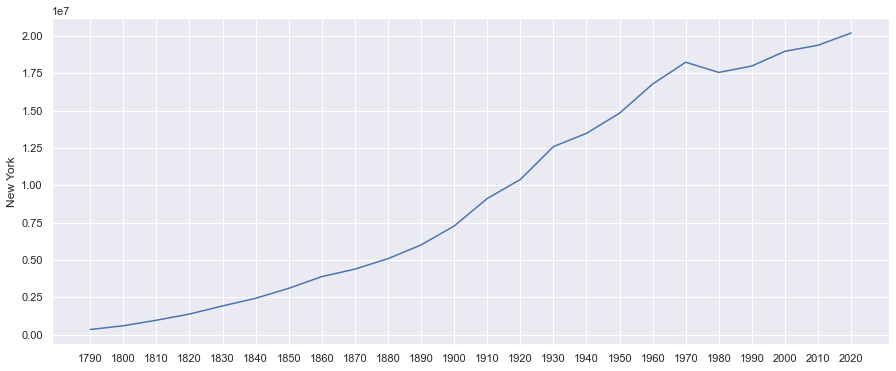

In [155]:
fig, ax = plt.subplots(figsize=(15,6))
# Graph population of new york
ny_pop = state_populations.drop(['acceptance'], axis=1).loc['New York']
sns.lineplot(data=ny_pop, ax=ax)


<AxesSubplot:ylabel='Hawaii'>

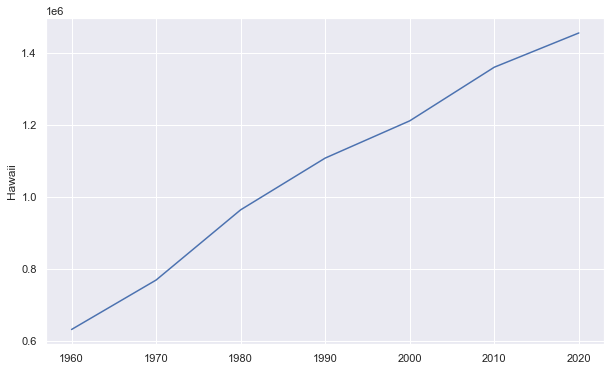

In [156]:
# Graph population of Hawaii
fig, ax = plt.subplots(figsize=(10,6))
hi_pop = state_populations.drop(['acceptance'], axis=1).loc['Hawaii']
sns.lineplot(data=hi_pop, ax=ax)

### How should we expect senate seats to be distributed?

#### Voting power - How do Senate seats translate into political power?

State borders are not drawn in a consistent way, nor is the population evenly distributed among them as we shall see shortly. The result is that some senators represent more Americans than do others. It's clear that the more people an American shares their senator with, the less influence that American has individually over their senator, and consequently the less influence they have on the Senate as a whole. In this way, the institution of the senate gives some Americans more political power and others less.

This uneven distribution is desirable for some. Some advance arguments involving concepts like "tyranny of the majority," and assert that, for example, this uneven distribution of power protects rural Americans from the more populous urban population.

Even if one agrees that senate power should be unevenly distributed, it's worth exploring how exactly the power is distributed, if the power is reaching the intended people, and quantifying just how unevenly power is or should be allotted. Let's see if we can figure some of that out.

#### Normal Distributions

Let's try and see if we can decide what we could expect for the distribution of population (and inversely, power) among the states.

A fair expectation might be to expect something close to a [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution). What that is and why we might expect it are related. Normal distrubtions can be interpreted as a group of data that cluster around some "center" with small deviations from it.

A simplified example might be the speed of a car trying to maintain a rate of 60 miles/hour. The driver will hover around 60 miles/hour with small deviations above and below it: sometimes 59, sometimes 61 miles/hour. Larger deviations, for example down to 55, or up to 65 miles/hour are possible but less likely than relatively smaller deviations.

If we wanted to distribute senate power roughly equally to Americans, state populations would have to be roughly equal. Since it's extremely impractical to redraw state lines every time the population distribution changes, even if senate power equality is our goal we should expect some small deviations from the average state population.

On the other hand, what if we intended to distribute power unequally? Even then we might still expect a normal distribution: most states could be relatively equal, while a small amount got a little more power, and a small amount got a little less.

Let's generate some normally distributed example data.

In [157]:
# generate normally distributed example data
rng = default_rng()
samples = 50
example_normal_dist = rng.standard_normal(size=samples)
# turn into dataframe
example_normal_dist_df = pd.DataFrame(example_normal_dist, columns=['normal_dist'])
example_normal_dist_df.describe()

,normal_dist
count,50.000000
mean,-0.239684
std,0.978307
min,-2.595911
25%,-0.897618
50%,-0.248009
75%,0.230999
max,2.310188


The data generated should have a mean of around 0. This is the number that the data should cluster around with varying deviations. The *standard deviation* (a way of measuring typical deviations from the mean, labeled as 'std') should be close to 1. The numbers 0 and 1 are the parameters for the "standard" normal distribution.

In a normal distribution there should be roughly the same amount of data points on each side of the mean, that is, it should be roughly symmetrical. We can quantify this symmetry or asymmetry with [skew](https://en.wikipedia.org/wiki/Skewness). The skew of our example set should be close to 0, meaning roughly 50% of the data is less than the mean, and roughly 50% is more.

In [158]:
# calculate the skew
example_normal_dist_df['normal_dist'].skew()

0.3381150357560557


Let's draw some plots in order to visualize the distribution of the data.

<AxesSubplot:ylabel='Density'>

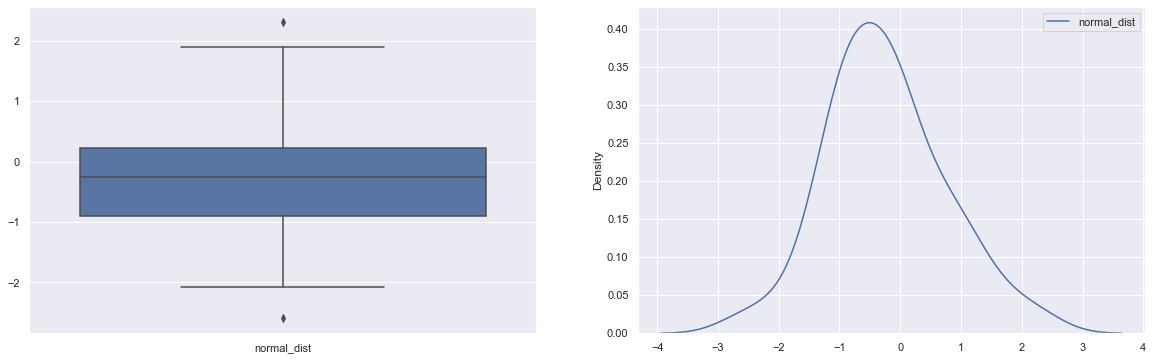

In [159]:
# make box plot and kde plot
fig, axs = plt.subplots(ncols=2, figsize=(20,6))
sns.boxplot(data=example_normal_dist_df, ax=axs[0])
sns.kdeplot(data=example_normal_dist_df, ax=axs[1])

Box plots and KDEs are nice ways to visualize the dispersion of a dataset. In other words, they help tell us where our data is and how much of it is there.

#### Box plot

The lefthand plot is a [Box Plot](https://en.wikipedia.org/wiki/Box_plot). More details are available at the link, but we'll go over some essential parts. The line in the middle of the box represents the median. Based on the properties of the standard normal distribution, the median of our generated data, and therefore this middle line should be around 0. The box itself represents the middle 50% of our data. That is, 50% of all our data falls within that box; similarly, 25% of the data ended up above the box, and the remaining 25% below the box. 

The last element we'll talk about are outliers, which appear as points disconnected from the rest of the box and its "whiskers." Outliers are points that are unusual relative to the rest of the data. We use the default settings of `seaborn` to calculate outliers. Since the example data is generated everytime this page is run, there may not be any outliers on the above box plot. I've saved an example of a box plot with normally distributed data and an outlier below the rest of the data:

![outlier example](outlier_example.png)


#### Kernel Density Estimation

The righthand plot is a [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE). KDE sounds complex, and can be, but for our purposes is quite simple to interpret. Basically it tells us where values were found in our dataset. You're most likely to find points close to 0, so the density (on the vertical axis) should be highest about there. The density being estimated is the probability density of finding a value at any particular point. Thus, as you get further away from 0 in either direction a normally distributed dataset, you're less likely to find data points, so the plot should taper off.

---

### How is the population distrubted amongst the states?

In [160]:
first_four = ['1790', '1800', '1810', '1820']
last_four = ['1990', '2000', '2010', '2020']
state_populations[last_four].describe()

,1990,2000,2010,2020
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,4.962059e+06,5.616997e+06,6.162876e+06,6.615195e+06
std,5.459772e+06,6.185580e+06,6.848235e+06,7.436143e+06
min,4.535880e+05,4.937820e+05,5.636260e+05,5.768510e+05
25%,1.299713e+06,1.735533e+06,1.833004e+06,1.869706e+06
50%,3.390548e+06,4.026890e+06,4.436370e+06,4.581796e+06
75%,5.898358e+06,6.281944e+06,6.680312e+06,7.566836e+06
max,2.976002e+07,3.387165e+07,3.725396e+07,3.953822e+07


### Box plots

<AxesSubplot:xlabel='2020', ylabel='Density'>

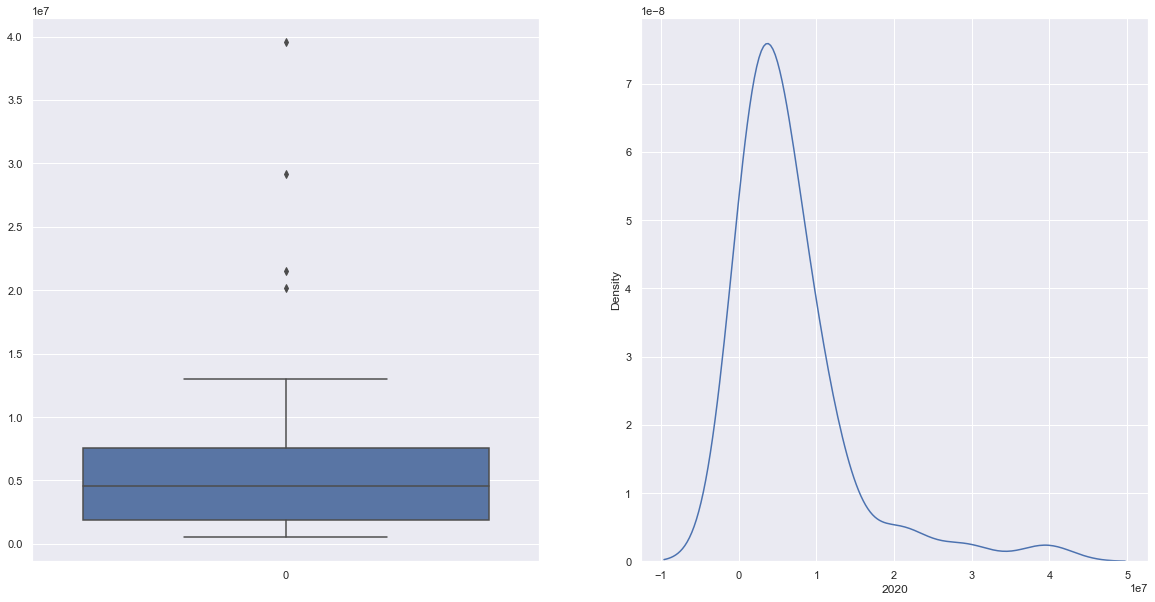

In [161]:
pop_2020 = state_populations['2020']

plt.figure(figsize=(20,10))
# make box plot and kde plot side by side
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
sns.boxplot(data=pop_2020, ax=ax1)
sns.kdeplot(data=pop_2020, ax=ax2)


Note the outliers in the plot on the left, and that they're only above the box. The plot on the right shows something similar with it's long "tail" on its righthand side.

<AxesSubplot:>

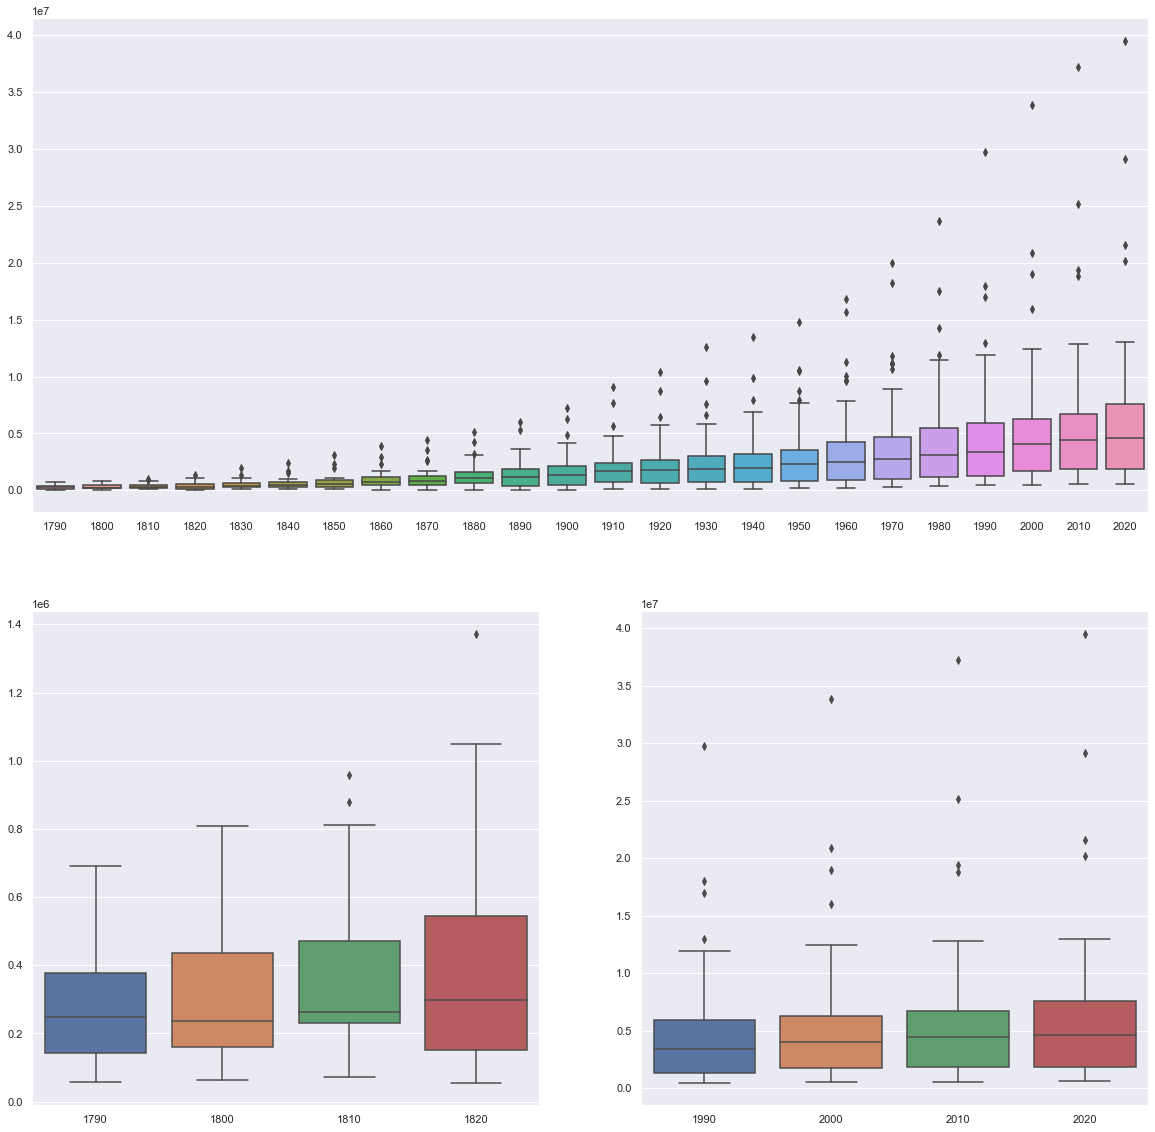

In [162]:
# plot box plots
plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

sns.boxplot(data=state_populations.loc[:,:'2020'], ax=ax1)
sns.boxplot(data=state_populations[first_four], ax=ax2)
sns.boxplot(data=state_populations[last_four], ax=ax3)

Because of the change in population it's difficult to compare directly the distributions between two years. For example:

<AxesSubplot:>

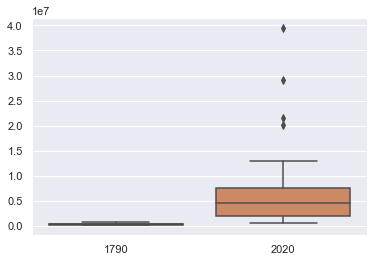

In [163]:
# plot 1790 and 2020 boxplots
sns.boxplot(data=state_populations[['1790', '2020']])

Why scaling and centering?

In thinking about senate power we're interested in the relationship between the populations of the states, rather than the raw numbers of the population. For example if over ten years each state's population has doubled, the raw population numbers have changed (doubled in fact), but each state has the same proportion of the population relative to other states as it did ten years ago. Consequently, each state's senate power has not changed over the ten years in question.

In summary, scaling and centering helps us compare the distribution (proportionally) of population amongst the states from year to year regardless of how the United States has grown as a whole.

In [164]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

year_column_names = state_populations.loc[:,:'2020'].columns
scaled_populations = sc.fit_transform(state_populations.loc[:,:'2020'])

# convert to dataframe
scaled_populations = pd.DataFrame(scaled_populations, columns=year_column_names)

<AxesSubplot:>

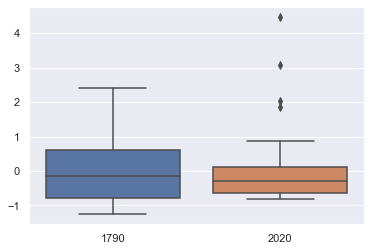

In [165]:
# plot 1790 and 2020 boxplots
sns.boxplot(data=scaled_populations[['1790', '2020']])

As we can see from the above graph, now we can really compare the distributions of population across different years.

<AxesSubplot:>

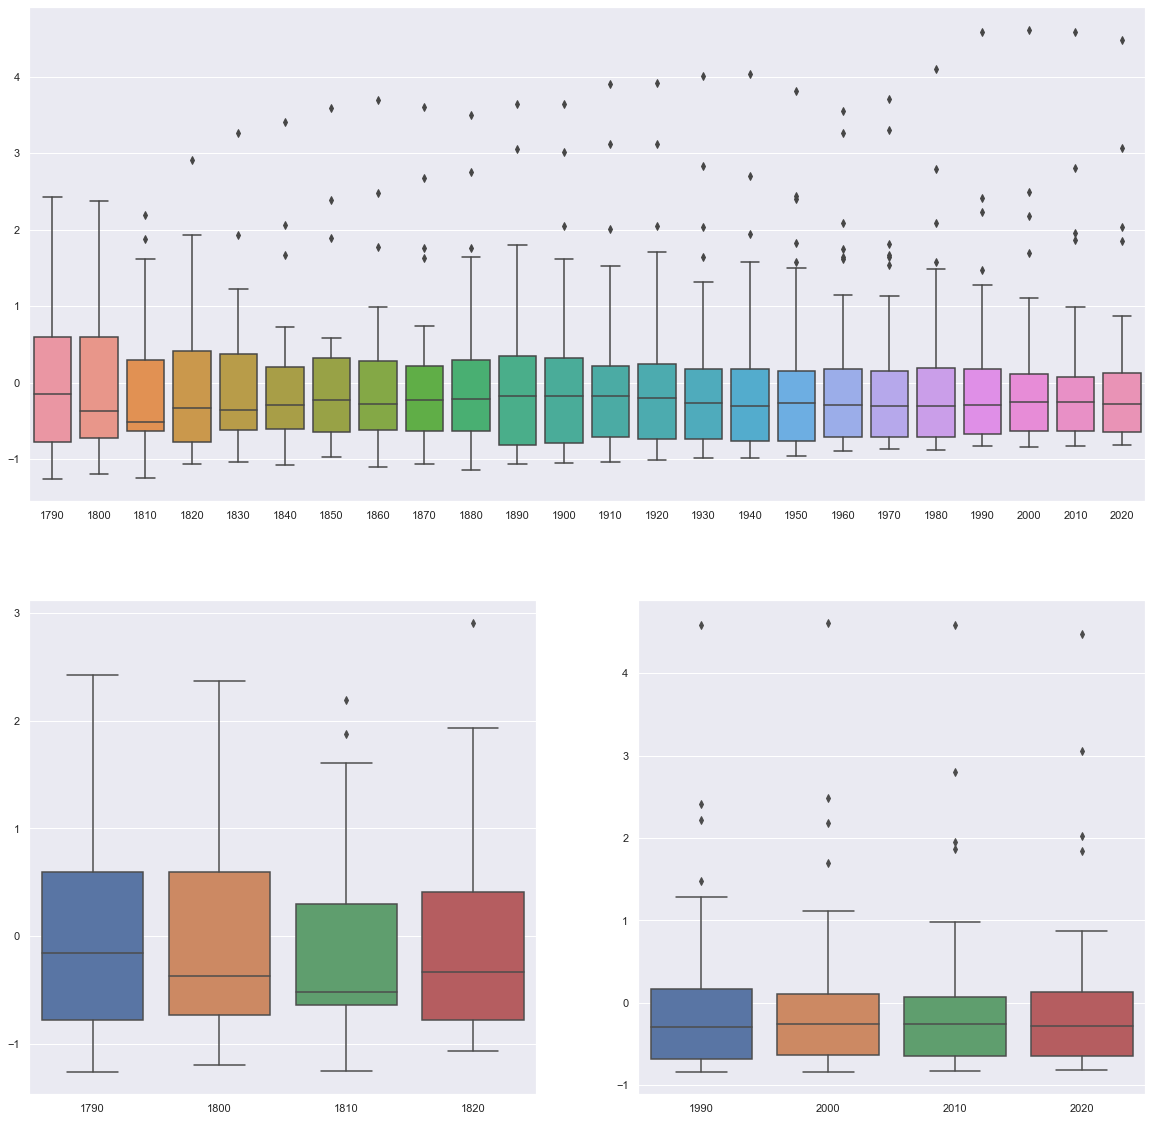

In [166]:
# plot box plots
plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

sns.boxplot(data=scaled_populations.loc[:,:'2020'], ax=ax1)
sns.boxplot(data=scaled_populations[first_four], ax=ax2)
sns.boxplot(data=scaled_populations[last_four], ax=ax3)

The distributions are pretty similar across the years. Most of the data is clustered below the mean. Some data points fall above the mean and often quite far away. The lower the state is, the more senate power each citizen of that state has. Therefore it seems that most states have a similar amount of power, and much more power than the larger outlier states.

Let's check out some violin plots, which are essentially boxplots where the sides of the boxes are KDEs.

<AxesSubplot:>

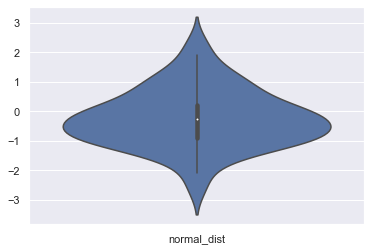

In [167]:
# violin plot of example data
sns.violinplot(data=example_normal_dist_df)

Above is a violin plot of our example normally distributed data. The center vertical line and dot correspond to our box plot, while the curved violin shaped sides represent the KDE.

<AxesSubplot:>

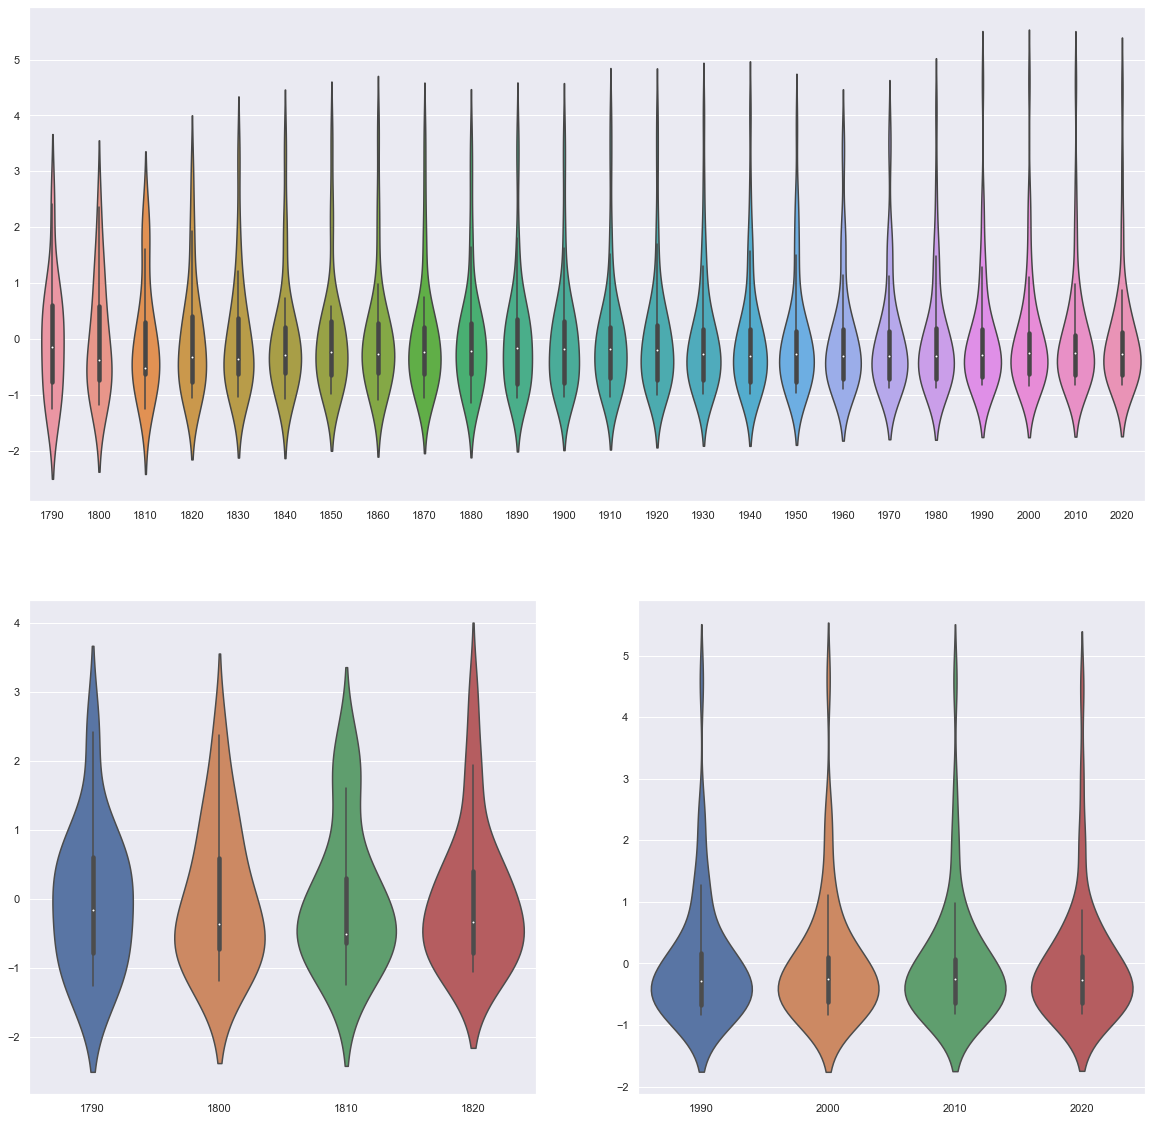

In [168]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

sns.violinplot(data=scaled_populations.loc[:,:'2020'], ax=ax1)
sns.violinplot(data=scaled_populations[first_four], ax=ax2)
sns.violinplot(data=scaled_populations[last_four], ax=ax3)

<AxesSubplot:>

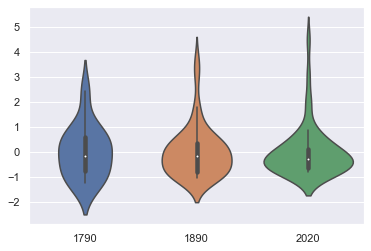

In [169]:
# plot 1790 and 2020 boxplots
sns.violinplot(data=scaled_populations[['1790', '1890', '2020']])

<AxesSubplot:ylabel='Density'>

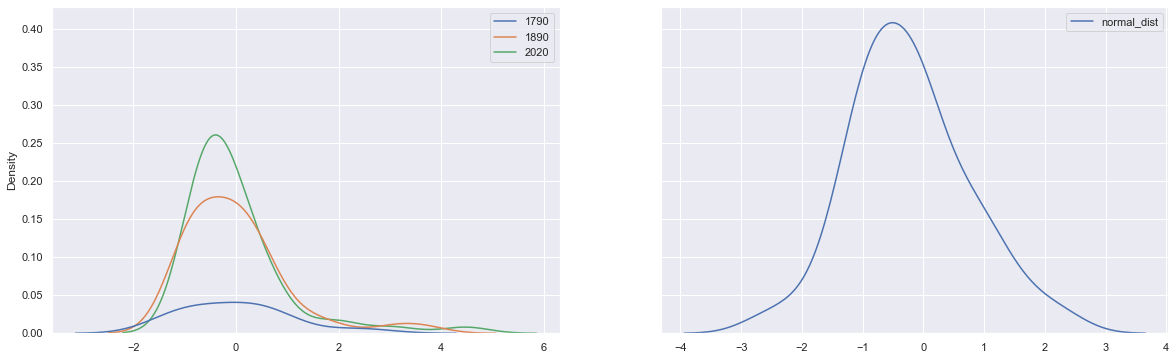

In [170]:
fig, axs = plt.subplots(ncols=2, figsize=(20,6), sharey=True)
sns.kdeplot(data=scaled_populations[['1790', '1890', '2020']], ax=axs[0])
sns.kdeplot(data=example_normal_dist_df, ax=axs[1])

Above left - a plot of KDEs from three different years of standardized population data.
Above right - a KDE plot of the normally distributed example data generated earlier.

Relative to a standard normal distribution it's clear that our data is pretty dispersed. That is to say, in every year, the state populations differ wildy - small states are significantly smaller than average, large states are significantly larger than average. Furthermore, the dispersion isn't symmetrical. As seen the the above plot on the left, the distributions have a long right "tail" (similar to the outliers we saw from our boxplots). What this means to us is that the largest states are much larger than all the other states, while the same can't be said for the smaller states.

It's clear that citizens living in more populous states have less senate power per citizen. Now we see that this difference in senate power is quite significant, and especially affected are those living in the most populous states

In [171]:
# sum the population of the four highest states in 2020
current_outliers = state_populations['2020'].nlargest(4).sum()

In [172]:
# percent of current outliers
current_outliers / us_totals['2020']

0.33315252236133225

One third of Americans live in the states `seaborn` calculated to be outliers for our boxplots. These are people who have significantly less senate power than other Americans.

---

### Have these effects changed over time?

In [173]:
from scipy.stats import skew
# find skew of 2020 population
skew(scaled_populations['2020'])

2.559817430587739

<AxesSubplot:>

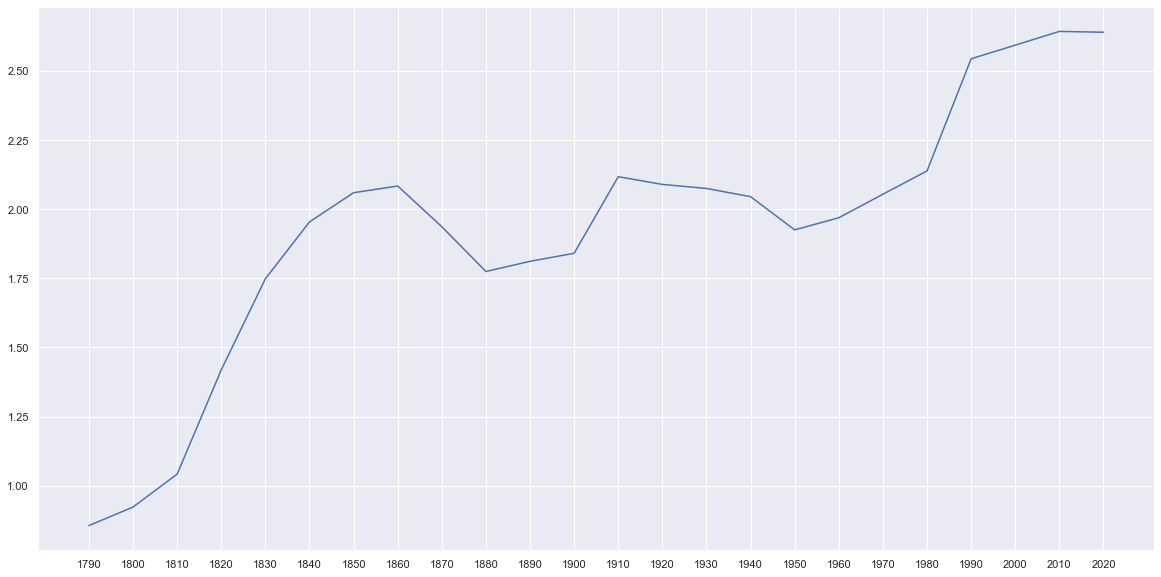

In [174]:
# find and plot skew for each column; pandas calculates skew differently than scipy but results are similar.
plt.figure(figsize=(20,10))
sns.lineplot(data=scaled_populations.skew())

The skewness of a dataset is a measure of its symmetry. A value of 0 would have data evenly distributed about some central point.

The skewness of our state population data was always positive, which above we interpreted as "the largest states are much larger than all the other states, while the same can't be said for the smaller states." The effect was always significant, but over time has increased relatively consistently over time, as seen in the plot above.


---

## Senate Power Demographics

Let's next explore what demographics have more or less power in the senate.

Of note, is that so far we've only looked at state populations. But the Senate has always had power over more people than are represented by states. Regions that are not states, such as Washington D.C. have no representation in the Senate. Additionally, for a large portion of the existence of the United States, a large number of enslaved people lived in and were counted as living in the States, but needless to say they had no representation in the Senate.  The data above counts enslaved people as part of the state populations.